# 🤖 Building a simple neural network

In this notebook a simple neural network composed of linear layers with `PReLU` intermediate activations is built.

## Imports

In [1]:
import pytreeclass as pytc  # our package
import jax  # JAX
import jax.numpy as jnp  # numpy on JAX
import jax.random as jr  # random number generators
import matplotlib.pyplot as plt  # plotting

## Layers

In [2]:
class Linear(pytc.TreeClass):
    def __init__(self, in_features: int, out_features: int, key: jr.KeyArray):
        """Linear layer"""
        self.weight = jax.nn.initializers.he_normal()(key, (in_features, out_features))
        self.bias = jnp.zeros((out_features,))

    def __call__(self, x: jax.Array) -> jax.Array:
        return x @ self.weight + self.bias

@pytc.autoinit
class PReLU(pytc.TreeClass):
    """https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html"""

    a: float = 0.25  # trainable parameter

    def __call__(self, x: jax.Array) -> jax.Array:
        return jnp.where(x >= 0, x, self.a * x)

## Create data

In [3]:
x = jr.uniform(jr.PRNGKey(100), (100, 1), minval=-1, maxval=1)
y = x**2


xb = jnp.array_split(x, 10)
yb = jnp.array_split(y, 10)

## Adding the layers together

In [4]:
# split the random number generator key
k1, k2, k3 = jr.split(jr.PRNGKey(0), 3)
layers = (
    Linear(1, 20, key=k1),
    PReLU(),
    Linear(20, 20, key=k2),
    PReLU(),
    Linear(20, 1, key=k3),
)


def sequential(layers: tuple[Linear | PReLU, ...], x: jax.Array) -> jax.Array:
    for layer in layers:
        x = layer(x)
    return x

## Create training functions

In [5]:
def loss_func(layers, x, y):
    return jnp.mean(jnp.square(sequential(layers, x) - y))


@jax.jit  # -> compile the function
def train_step(layers, x, y, lr=1e-3) -> jax.Array:
    layers_grad = jax.grad(loss_func)(layers, x, y)
    layers = jax.tree_map(lambda x, y: x - lr * y, layers, layers_grad)
    return layers

## Train

In [6]:
for i in range(10_000):
    for xbb, ybb in zip(xb, yb):
        layers = train_step(layers, xbb, ybb)

## Plot the resulrs

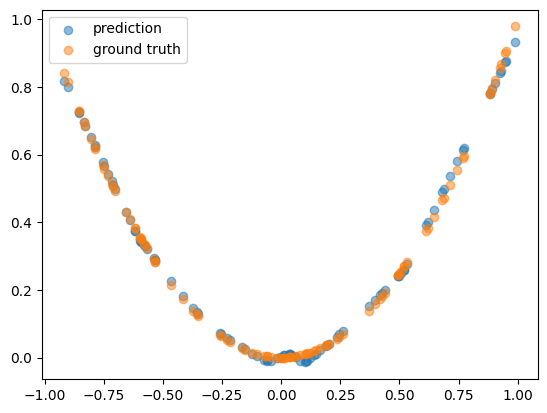

In [7]:
plt.scatter(x, sequential(layers, x), label="prediction", alpha=0.5)
plt.scatter(x, y, label="ground truth", alpha=0.5)
plt.legend()
plt.show()

## View layers after training

In [8]:
layers

(Linear(
   weight=f32[1,20](μ=0.33, σ=1.37, ∈[-1.90,2.46]), 
   bias=f32[20](μ=-0.03, σ=0.07, ∈[-0.15,0.11])
 ),
 PReLU(a=f32[](μ=0.37, σ=0.00, ∈[0.37,0.37])),
 Linear(
   weight=f32[20,20](μ=0.00, σ=0.31, ∈[-0.71,0.72]), 
   bias=f32[20](μ=-0.03, σ=0.07, ∈[-0.29,0.05])
 ),
 PReLU(a=f32[](μ=-0.03, σ=0.00, ∈[-0.03,-0.03])),
 Linear(
   weight=f32[20,1](μ=0.14, σ=0.29, ∈[-0.36,0.66]), 
   bias=f32[1](μ=-0.02, σ=0.00, ∈[-0.02,-0.02])
 ))

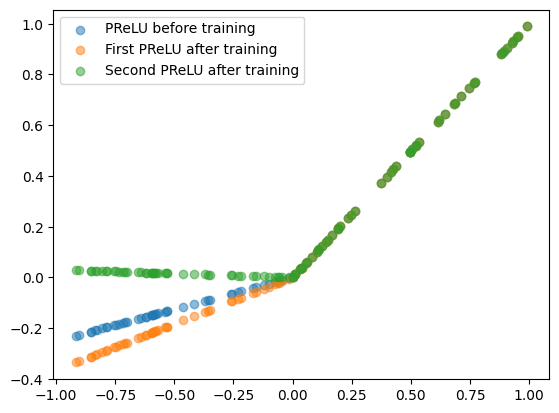

In [9]:
plt.scatter(x, PReLU()(x), label="PReLU before training", alpha=0.5)
plt.scatter(x, layers[1](x), label="First PReLU after training", alpha=0.5)
plt.scatter(x, layers[3](x), label="Second PReLU after training", alpha=0.5)
plt.legend()